In [32]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [33]:
TRAIN_DIR = 'images/train'
TEST_DIR = 'images/test'
IMAGE_SIZE = 48
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

cuda


In [34]:
class EmotionDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

In [35]:
def create_dataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        label_dir = os.path.join(dir, label)
        if os.path.isdir(label_dir):  # Ensure it's a directory
            for image_name in os.listdir(label_dir):
                image_paths.append(os.path.join(dir, label, image_name))
                labels.append(label)
            print(f"{label} completed")
    return image_paths, labels

In [36]:
def get_label_idx(label_name):
    return EMOTIONS.index(label_name)

In [37]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [38]:
# Create datasets and loaders
def create_datasets():
    # Get train data
    train_image_paths, train_label_names = create_dataframe(TRAIN_DIR)
    train_labels = [get_label_idx(label) for label in train_label_names]

    # Get test data
    test_image_paths, test_label_names = create_dataframe(TEST_DIR)
    test_labels = [get_label_idx(label) for label in test_label_names]

    # Create datasets
    train_dataset = EmotionDataset(train_image_paths, train_labels, transform)
    test_dataset = EmotionDataset(test_image_paths, test_labels, transform)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [39]:
class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)

        # Calculate the size after convolutions
        # After 3 pooling layers of stride 2, the 48x48 image becomes 6x6
        self.flat_features = 512 * 6 * 6

        # Fully connected layers
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.dropout4 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout5 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Convolutional layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten
        x = x.view(-1, self.flat_features)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout4(x)
        x = F.relu(self.fc2(x))
        x = self.dropout5(x)
        x = self.fc3(x)

        return x

In [40]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Validation'):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(test_loader.dataset)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save best model
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(model.state_dict(), 'emotion_model.pth')
            print(f'Model saved with accuracy: {best_accuracy:.4f}')

    print(f'Best validation accuracy: {best_accuracy:.4f}')

In [41]:
def predict_emotion(model, image_path):
    model.eval()

    # Open and preprocess the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return EMOTIONS[predicted.item()]

Using device: cuda
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed
angry completed
disgust completed
fear completed
happy completed
neutral completed
sad completed
surprise completed


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.88it/s]


Epoch 1/30:
Train Loss: 1.6566 | Train Acc: 0.3367
Val Loss: 1.5005 | Val Acc: 0.4172
Model saved with accuracy: 0.4172


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.98it/s]


Epoch 2/30:
Train Loss: 1.4302 | Train Acc: 0.4468
Val Loss: 1.3435 | Val Acc: 0.4812
Model saved with accuracy: 0.4812


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.99it/s]


Epoch 3/30:
Train Loss: 1.3049 | Train Acc: 0.5021
Val Loss: 1.2434 | Val Acc: 0.5263
Model saved with accuracy: 0.5263


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.12it/s]


Epoch 4/30:
Train Loss: 1.2122 | Train Acc: 0.5362
Val Loss: 1.1798 | Val Acc: 0.5471
Model saved with accuracy: 0.5471


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.06it/s]


Epoch 5/30:
Train Loss: 1.1328 | Train Acc: 0.5705
Val Loss: 1.1477 | Val Acc: 0.5637
Model saved with accuracy: 0.5637


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.31it/s]


Epoch 6/30:
Train Loss: 1.0629 | Train Acc: 0.5945
Val Loss: 1.1324 | Val Acc: 0.5705
Model saved with accuracy: 0.5705


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.23it/s]


Epoch 7/30:
Train Loss: 1.0013 | Train Acc: 0.6217
Val Loss: 1.1318 | Val Acc: 0.5716
Model saved with accuracy: 0.5716


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.34it/s]


Epoch 8/30:
Train Loss: 0.9344 | Train Acc: 0.6466
Val Loss: 1.1207 | Val Acc: 0.5892
Model saved with accuracy: 0.5892


Validation: 100%|██████████| 111/111 [00:03<00:00, 33.08it/s]


Epoch 9/30:
Train Loss: 0.8676 | Train Acc: 0.6739
Val Loss: 1.1217 | Val Acc: 0.5824


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.81it/s]


Epoch 10/30:
Train Loss: 0.8116 | Train Acc: 0.6978
Val Loss: 1.1402 | Val Acc: 0.5848


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.94it/s]


Epoch 11/30:
Train Loss: 0.7552 | Train Acc: 0.7178
Val Loss: 1.1395 | Val Acc: 0.5920
Model saved with accuracy: 0.5920


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.33it/s]


Epoch 12/30:
Train Loss: 0.7081 | Train Acc: 0.7381
Val Loss: 1.1530 | Val Acc: 0.5903


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.64it/s]


Epoch 13/30:
Train Loss: 0.6646 | Train Acc: 0.7531
Val Loss: 1.1724 | Val Acc: 0.5968
Model saved with accuracy: 0.5968


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.76it/s]


Epoch 14/30:
Train Loss: 0.6213 | Train Acc: 0.7728
Val Loss: 1.2019 | Val Acc: 0.5893


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.73it/s]


Epoch 15/30:
Train Loss: 0.5928 | Train Acc: 0.7810
Val Loss: 1.2094 | Val Acc: 0.5969
Model saved with accuracy: 0.5969


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.81it/s]


Epoch 16/30:
Train Loss: 0.5561 | Train Acc: 0.7963
Val Loss: 1.2298 | Val Acc: 0.5979
Model saved with accuracy: 0.5979


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.57it/s]


Epoch 17/30:
Train Loss: 0.5209 | Train Acc: 0.8103
Val Loss: 1.2657 | Val Acc: 0.5982
Model saved with accuracy: 0.5982


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.62it/s]


Epoch 18/30:
Train Loss: 0.4964 | Train Acc: 0.8184
Val Loss: 1.2533 | Val Acc: 0.5951


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.20it/s]


Epoch 19/30:
Train Loss: 0.4836 | Train Acc: 0.8249
Val Loss: 1.2919 | Val Acc: 0.5968


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.43it/s]


Epoch 20/30:
Train Loss: 0.4649 | Train Acc: 0.8331
Val Loss: 1.3257 | Val Acc: 0.5899


Validation: 100%|██████████| 111/111 [00:03<00:00, 30.05it/s]


Epoch 21/30:
Train Loss: 0.4388 | Train Acc: 0.8407
Val Loss: 1.3817 | Val Acc: 0.5992
Model saved with accuracy: 0.5992


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.87it/s]


Epoch 22/30:
Train Loss: 0.4313 | Train Acc: 0.8464
Val Loss: 1.3297 | Val Acc: 0.5950


Validation: 100%|██████████| 111/111 [00:03<00:00, 31.82it/s]


Epoch 23/30:
Train Loss: 0.4093 | Train Acc: 0.8500
Val Loss: 1.3382 | Val Acc: 0.5923


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.16it/s]


Epoch 24/30:
Train Loss: 0.4017 | Train Acc: 0.8547
Val Loss: 1.3699 | Val Acc: 0.5930


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.21it/s]


Epoch 25/30:
Train Loss: 0.3805 | Train Acc: 0.8643
Val Loss: 1.4095 | Val Acc: 0.5992


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.43it/s]


Epoch 26/30:
Train Loss: 0.3741 | Train Acc: 0.8651
Val Loss: 1.3869 | Val Acc: 0.6008
Model saved with accuracy: 0.6008


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.82it/s]


Epoch 27/30:
Train Loss: 0.3587 | Train Acc: 0.8721
Val Loss: 1.4101 | Val Acc: 0.5962


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.60it/s]


Epoch 28/30:
Train Loss: 0.3502 | Train Acc: 0.8782
Val Loss: 1.4778 | Val Acc: 0.5916


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.41it/s]


Epoch 29/30:
Train Loss: 0.3449 | Train Acc: 0.8814
Val Loss: 1.4405 | Val Acc: 0.5941


Validation: 100%|██████████| 111/111 [00:03<00:00, 32.50it/s]

Epoch 30/30:
Train Loss: 0.3232 | Train Acc: 0.8865
Val Loss: 1.4736 | Val Acc: 0.5947
Best validation accuracy: 0.6008


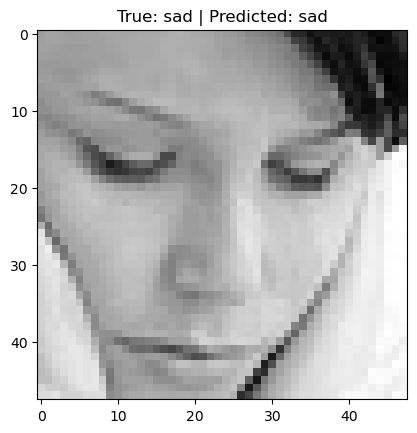

Original image is of sad
Model prediction is sad


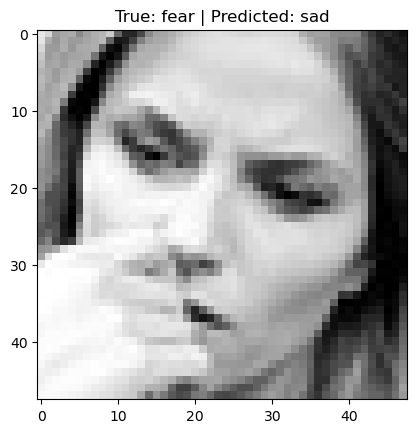

Original image is of fear
Model prediction is sad


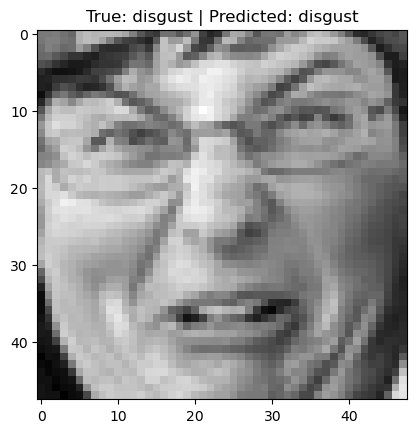

Original image is of disgust
Model prediction is disgust


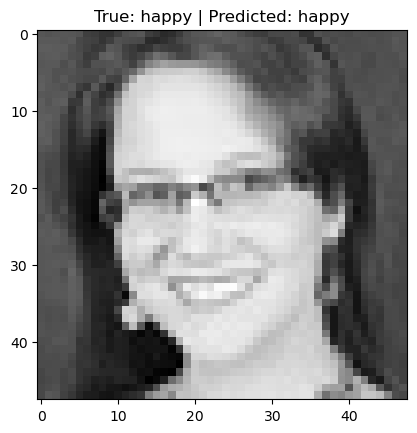

Original image is of happy
Model prediction is happy


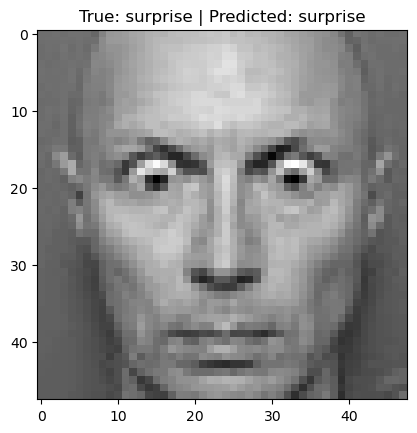

Original image is of surprise
Model prediction is surprise


In [42]:
def main():
    print(f"Using device: {DEVICE}")

    # Create data loaders
    train_loader, test_loader = create_datasets()

    # Initialize model
    model = EmotionCNN().to(DEVICE)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train model
    train_model(model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS)

    # Load best model
    model.load_state_dict(torch.load('emotion_model.pth'))

    # Test some example images
    test_images = [
        'images/train/sad/42.jpg',
        'images/train/fear/2.jpg',
        'images/train/disgust/299.jpg',
        'images/train/happy/7.jpg',
        'images/train/surprise/15.jpg'
    ]

    for image_path in test_images:
        true_label = image_path.split('/')[-2]
        predicted_label = predict_emotion(model, image_path)

        # Display image with prediction
        img = Image.open(image_path).convert('L')
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {true_label} | Predicted: {predicted_label}')
        plt.show()
        print(f"Original image is of {true_label}")
        print(f"Model prediction is {predicted_label}")

if __name__ == "__main__":
    main()